In [68]:
import pandas as pd
import numpy as np
import random

import gym
from gym.spaces import Discrete, Box, Dict

from collections import OrderedDict

import matplotlib.pyplot as plt

In [72]:
class LifecycleEnv(gym.Env):
    def __init__(self):
        # Here we define the choices on consumption and equity allocation
        self.action_space = Dict({"equity_allocation": Discrete(101),
                                  "consumption": Discrete(200)})
        # Set starting variables
        self.wealth = 0
        self.starting_income = 100
        self.income = self.starting_income
        self.starting_age = 20
        self.age = self.starting_age
        self.retirement_age = 70
        self.terminal_age = 115
        self.max_wealth = 1000
        self.total_consumption = 0
        # Here we create our observation space
        self.observation_space = Dict({"age": Discrete(self.terminal_age - self.starting_age + 1),
                                       "obs_wealth": Discrete(self.max_wealth + 1)})

    def step(self, action):
        # Income reduces when you retire
        if self.age > self.retirement_age:
            self.income = 0
        # define market returns
        risk_return = 0.05
        risk_free_return = 0.02
        # tranformation
        #print(action)
        action_equity_allocation = action["equity_allocation"] / 100
        # Apply action
        portfolio_return = risk_return * \
            action_equity_allocation + risk_free_return * \
            (1 - action_equity_allocation)
        self.wealth = (1 + portfolio_return) * (self.wealth -
                                                action["consumption"]) + self.income
        self.total_consumption += action["consumption"]
        # force wealth to be in grid - need to work on this
        if self.wealth > self.max_wealth:
            self.wealth = self.max_wealth
        if self.wealth < 0:
            self.wealth = 0
        self.wealth = int(self.wealth)
        # Time passes (philosophical consideration here)
        self.age += 1
        # Complete step if agent is older than terminal age
        if self.age == self.terminal_age:
            done = True
            reward = self.total_consumption
        else:
            done = False
            reward = 0
        # Placeholder for info
        info = {"age": self.age, "wealth": self.wealth, "consumption": action["consumption"], "equity_allocation": action_equity_allocation}
        state = {"age": self.age, "wealth": self.wealth}
        return state, reward, done, info

    def render(self, mode='human'):
        # no urgent need for this
        pass

    def reset(self):
        # Resetting age and wealth
        self.wealth = 0
        self.age = self.starting_age
        self.income = self.starting_income
        self.total_consumption = 0
        state = {"age": self.age, "wealth": self.wealth}
        return state


env = LifecycleEnv()
# Observation and action space
print("The observation space: {}".format(env.observation_space))
print("The action space: {}".format(env.action_space))


The observation space: Dict(age:Discrete(96), obs_wealth:Discrete(1001))
The action space: Dict(consumption:Discrete(200), equity_allocation:Discrete(101))


In [98]:
# Hyperparameters
epochs = 10000
num_steps = env.terminal_age - env.starting_age
epsilon = 0.1
alpha = 0.1
gamma = 0.6

# env setup
state = env.reset()
best_action = OrderedDict()
info_df = pd.DataFrame(
    columns=("age", "wealth", "consumption", "equity_allocation"))
# my q table consist of 2 state actions and 2 observation spaces
# I need to change one of the observation space variables into a continuos one and use function approximation
q_table = np.zeros([env.observation_space["age"].n, env.observation_space["obs_wealth"].n,
                    env.action_space["equity_allocation"].n, env.action_space["consumption"].n])

for epoch in range(epochs):
    # this is a greedy implementation
    epsilon = 1 - (epoch / epochs)
    for step in range(num_steps):
        # take random action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            # here I select the best action based on my q table
            q = q_table[state["age"] - env.starting_age, state["wealth"]]
            max_q_index = np.unravel_index(np.argmax(q, axis=None), q.shape)
            best_action['consumption'] = max_q_index[1]
            best_action['equity_allocation'] = max_q_index[0]
            action = best_action  # Exploit learned values

        # apply the action
        next_state, reward, done, info = env.step(action)

        # Render the env
        info_df = info_df.append(info, ignore_index=True) 
        
        old_value = q_table[state["age"] - env.starting_age, state["wealth"], action["equity_allocation"], action["consumption"]]
        next_max = np.max(q_table[next_state["age"] - env.starting_age, next_state["wealth"]])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state["age"] - env.starting_age, state["wealth"], action["equity_allocation"], action["consumption"]] = new_value

        # If the episode is up, then start another one
        if done:
            if epoch < epochs - 1:
                info_df = pd.DataFrame(
                    columns=("age", "wealth", "consumption", "equity_allocation"))
            env.reset()

# print(info_df.set_index("age"))
info_df.set_index("age").plot(secondary_y=["equity_allocation"])

# Close the env
env.close()


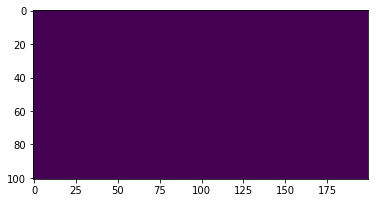

In [ ]:
plt.imshow(q_table[80].mean(axis=0))

In [83]:
info_df

,age,wealth,consumption,equity_allocation
0,21.0,28.0,68.0,0.87
1,22.0,58.0,68.0,0.87
2,23.0,89.0,68.0,0.87
3,24.0,121.0,68.0,0.87
4,25.0,155.0,68.0,0.87
...,...,...,...,...
90,111.0,0.0,68.0,0.87
91,112.0,0.0,68.0,0.87
92,113.0,0.0,68.0,0.87
93,114.0,0.0,68.0,0.87


In [86]:
q_table.nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([ 0,  0,  1,  2,  2,  2,  3,  3,  3,  4,  5,  6,  6,  8, 10, 11, 12,
        12, 13, 14, 15, 18, 19, 19, 20, 20, 20, 21, 21, 23, 24, 25, 25, 27,
        27, 28, 29, 29, 30, 31, 34, 37, 42, 45, 45, 48, 49, 49, 54, 54, 54,
        56, 56, 57, 57, 58, 61, 61, 61, 63, 64, 65, 65, 66, 67, 67, 68, 68,
        69, 70, 

In [82]:
q_table[80].mean(axis=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])